In [91]:
from __future__ import annotations

from typing import Any, Dict, List, Optional, Annotated, Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph ,START , END
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
import operator
import os
from langchain_tavily import TavilySearch
from dotenv import load_dotenv
load_dotenv()

True

In [93]:
!pip install -U langchain-tavily

In [ ]:
engine = TavilySearch(max_results=2, api_key=os.getenv("TAVILY_API_KEY"),
                             search_depth = "advanced")

In [95]:
# result = engine.invoke("Gold price as of today at this moment??")
# result

In [96]:
# result["results"][1]["content"]

In [97]:
# from tavily import TavilyClient

# tavily_client = TavilyClient(api_key="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")
# response = tavily_client.research("What are the latest developments in AI?")

# print(response)

In [98]:
# response

In [99]:

model = ChatOpenAI(
    model="openai/gpt-4o-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key= Api_key
)


# Core Models

In [100]:
class Task(BaseModel):
    id : int
    title: str
    goal : str = Field(...,
                       description="One sentence describing what the reader should be able to do/understand after this section.")
    bullets : list[str] = Field(...,
                                min_length=3, max_length=5,
                                description="3-5 bullet points describing the key takeaways of this section."
                                "Each bullet point should be a single sentence and should not exceed 20 words.")
    target_words : int = Field(...,
                                description="The target word count for this section. Should be between 150 and 500 words.")
    section_type : Literal["introduction", "core","examples","checklist", "common_mistakes", "body", "conclusion"] = Field(...,
                                                        description="The type of the section. Can be 'introduction', 'body', or 'conclusion'."
                                                                    "Use coomon mistakes exactly once in the plan if required .")
    tags : List[str] = Field(default_factory=list)
    requires_research : bool = False
    requires_citeations : bool = False
    requires_code : bool = False
    code_language : Optional[str] = None
    code_description : Optional[str] = None




class Plan(BaseModel):
    blog_title : str
    audience : str = Field(...,
                        description="A one sentence description of the target audience for this blog post. This should include information about the reader's background, interests, and what they hope to gain from reading the blog post.")
    tone : str = Field(...,
                        description="A one sentence description of the tone and style of the blog post. This should include information about the desired level of formality, use of humor, and overall writing style that should be used in the blog post." \
                        "For example, the tone could be described as 'conversational and engaging with a touch of humor' or 'professional and informative with a formal tone'." \
                        "The tone should be consistent throughout the blog post and should align with the target audience and the topic of the blog post.")
    blog_kind : Literal["how-to", "listicle", "opinion", "case-study", "news", "interview", "explainer", "System_design"] = "explainer"
    constraints : List[str] = Field(default_factory=list)
    task: list[Task]



class EvidenceItem(BaseModel):
    title : str
    url : str
    published_at : Optional[str] = None
    snippet : Optional[str] = None
    source : Optional[str] = None


class RouterDecision(BaseModel):
    need_research : bool 
    mode : Literal["write", "research", "code","closed book","Hybrid","Openbook"] 
    quaries : List[str] = Field(default_factory=list)


class EvidencePack(BaseModel):
    evidence_items : List[EvidenceItem] = Field(default_factory=list)

In [101]:
from typing import TypedDict
class AgentState(TypedDict):
    topic: str
    mode : str
    needs_research : bool
    quaries : List[str]
    evidence : List[EvidenceItem]
    plan: Optional[Plan]
    sections: Annotated[List[tuple[int,str]], operator.add]  # worker 4 , section md 
    final: str

# Router 

In [ ]:
#
ROUTER_SYSTEM = """You are a routing module for a high experience blog planner.
Decide whether web research is needed BEFORE planning.
Modes:
closed_book (needs_research=false):
- Evergreen topics where correctness does not depend on recent facts (concepts, fundamentals).
hybrid (needs_research=true):
- Mostly evergreen but needs up-to-date examples/tools/models to be useful.
open_book (needs_research=true):
- Mostly volatile: weekly roun ups, "this week", "latest", rankings, pricing, policy/regulation.
If needs_research=true:
Output 310 high-signal queries.
Queries should be scoped and specific (avoid generic queries like just "AI" or "LLM").
- If user asked for "last week/this week/latest", reflect that constraint IN THE QUERIES.
"""

def router(state : AgentState) -> dict :
    topic = state['topic']
    decider = model.with_structured_output(RouterDecision)
    messages = [
        SystemMessage(content=ROUTER_SYSTEM),
        HumanMessage(content=f"Topic: {topic}"),
    ]
    response = decider.invoke(messages)
    return {
        "needs_research" : response.needs_research,
        "mode" : response.mode,
        "queries" : response.queries    
    }



def route_next (state : AgentState) -> str:
    return "research" if state['needs_research'] else "orchestrator"


# Tavily Search 

In [103]:
{'query': 'Gold price as of today at this moment??',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.150currency.com/',
   'title': 'Gold Price in U.S. Dollar Tuesday, 24 February 2026',
   'content': 'The current gold price per ounce in USD as of Tuesday, 24 February 2026 is 166.13 USD. This is the price for 24K gold per gram, which is the purest form of gold',
   'score': 0.98561,
   'raw_content': None},
  {'title': 'Gold Price Today | Price of Gold Per Ounce | 24 Hour Spot ...',
   'url': 'https://www.kitco.com/charts/gold',
   'content': '1 day ago · Live Gold Charts and Gold Spot Price from International Gold Markets, Prices from New York, London, Hong Kong and Sydney provided by Kitco .',
   'score': 0.9855,
   'raw_content': None}],
 'response_time': 5.71,
 'request_id': 'e897f5bb-374e-406c-ab16-16fbdaa98542'}

{'query': 'Gold price as of today at this moment??',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.150currency.com/',
   'title': 'Gold Price in U.S. Dollar Tuesday, 24 February 2026',
   'content': 'The current gold price per ounce in USD as of Tuesday, 24 February 2026 is 166.13 USD. This is the price for 24K gold per gram, which is the purest form of gold',
   'score': 0.98561,
   'raw_content': None},
  {'title': 'Gold Price Today | Price of Gold Per Ounce | 24 Hour Spot ...',
   'url': 'https://www.kitco.com/charts/gold',
   'content': '1 day ago · Live Gold Charts and Gold Spot Price from International Gold Markets, Prices from New York, London, Hong Kong and Sydney provided by Kitco .',
   'score': 0.9855,
   'raw_content': None}],
 'response_time': 5.71,
 'request_id': 'e897f5bb-374e-406c-ab16-16fbdaa98542'}

In [104]:
def tavily_search(quary:str , max_results : int = 5) -> List[EvidenceItem] :
    engine = TavilySearch(max_results=max_results, api_key=TAVILY_API_KEY,
                             search_depth = "advanced")
    result = engine.invoke(quary)
    evidence_items = []
    for item in result['results']:
        evidence_items.append(EvidenceItem(
            title=item['title'],
            url=item['url'],
            published_at=item.get('published_at'),
            snippet=item.get('content'),
            source=item.get('source')
        ))
    return evidence_items

# Research 

In [105]:
RESEARCH_SYSTEM = """You are a research synthesizer for technical and Skilled Blog writing.

Given raw web search results, produce a deduplicated list of
Rules:
- Only include items with a non-empty url.
- Prefer relevant + authoritative sources (company blogs, docs, reputable outlets).
- If a published date is explicitly present in the result payload, keep it as YYYY-MM-DD.
- If missing or unclear, set published_at = null. Do NOT guess.
- Keep snippets short.
- Deduplicate by URL
"""

def research(state : AgentState) -> dict:
    quaries = state.get('quaries', [])
    max_results_per_query = 6
    raw_results : List[dict] = []

    for quary in quaries:
        raw_results.extend(tavily_search(quary, max_results=max_results_per_query))

    if not raw_results:
        return {"evidence": []}
    
    extractor = model.with_structured_output(EvidenceItem)

    pack = extractor.invoke(
        [
            SystemMessage(content=RESEARCH_SYSTEM),
            HumanMessage(content=f"Raw search results: \n{raw_results}")
        ]
    )

    # Deduplicate the URLS

    dedup = {}
    for item in pack:
        if item.url and item.url not in dedup:
            dedup[item.url] = item
    return {
        "evidence": list(dedup.values())
        }

# Orchestrator

In [106]:
ORCH_SYSTEM = """You are a senior technical writer and developer advocate.
Your job is to produce a highly actionable outline for a technical blog post.

Hard requirements:
Create 59 sections (tasks) suitable for the topic and audience.
Each task must include:
1) goal (1 sentence)
2) 36 bullets that are concrete, specific, and non-overlapping
3) target word count (120 550)

Quality bar:
- Assume the reader is a developer; use correct terminology.
- Bullets must be actionable: build/compare/measure/verify/debug.
- Ensure the overall plan includes at least 2 of these somewhere:
 *minimal code sketch / MWE (set requires_code=True for that section)
 *edge cases / failure modes
 *performance/cost considerations
 *security/privacy considerations (if relevant)
 *debugging/observability tips

Grounding Rules:
 - Mode Close BooK : rely solely on your internal knowledge and expertise. Do not include any information that is not already in your training data. This mode is suitable for evergreen topics where correctness does not depend on recent facts (concepts, fundamentals).
 - Mode Open Book : You have access to the following pieces of evidence (presented as a list of title + url + snippet).
   You can use this evidence to inform your outline, but you should not feel compelled to use all of it.
   Use your judgment to determine what is relevant and useful for the outline.
   You can also use your internal knowledge and expertise in addition to the provided evidence.    
 - Mode Hybrid : You have access to the following pieces of evidence (presented as a list of title + url + snippet).
   You should use this evidence to inform your outline, but you should also rely on your internal
   knowledge and expertise to fill in any gaps and provide additional insights. Use your judgment to determine 
   how to best combine the provided evidence with your internal knowledge to create a comprehensive and actionable outline.   

Output Must Match the Plan Schema 
"""


def orchestrator(state : AgentState) -> dict:

    planner = model.with_structured_output(Plan)
    topic = state['topic']
    audience = state['audience']
    tone = state['tone']
    blog_kind = state['blog_kind']
    evidence = state.get('evidence', [])
    mode = state['mode']

    messages = [
        SystemMessage(content=ORCH_SYSTEM),
        HumanMessage(content=f"Topic: {topic}\nAudience: {audience}\nTone: {tone}\nBlog Kind: {blog_kind}\nMode: {mode}\nEvidence: {evidence}")
    ]

   
    plan = planner.invoke(messages)
    return {
        "plan": plan
    }

In [107]:
# def orchestrator(state : AgentState) -> dict:
#     plan = model.with_structured_output(Plan).invoke(
#         [SystemMessage(
#             content= (
#                      f"""Create a comprehensive, research-driven execution plan for producing a technically rigorous, high-authority blog post on the provided topic. You are a senior technical writer with 20+ years of experience in engineering, research communication, and industry analysis. The output must reflect professional depth, analytical clarity, and domain expertise.

#         The response must include:

#         A compelling, SEO-optimized blog title aligned with search intent and industry relevance.

#         5–7 logically sequenced tasks, each representing a major section of the blog.

#         For each task, provide:

#         Task Name (clear, action-oriented)

#         Section Title (intended blog heading)

#         Detailed Description (3–5 sentences explaining:

#         Core concepts to cover

#         Key technical or strategic questions to answer

#         Data sources (research papers, industry reports, benchmarks, standards, real-world case studies)

#         Whether diagrams, code snippets, architecture examples, mathematical intuition, or practical workflows should be included

#         The purpose of this section in strengthening credibility and reader understanding)

#         The plan must:

#         Progress logically (context → foundations → deep analysis → evidence → counterarguments → future outlook → conclusion)

#         Cover technical, economic, ethical, and practical dimensions where applicable

#         Include examples, code snippets, system architecture outlines, or workflow demonstrations if relevant

#         Address limitations, risks, and trade-offs

#         Avoid generic statements and surface-level explanations

#         The final plan should enable the creation of a technically sound, insightful, and publication-ready article suitable for engineers, researchers, or decision-makers."""
#          )
#         ),
#         HumanMessage(content=f"Topic: {state.topic}")]
#     )
#     return {"plan" : plan}

# Fanout And Worker

In [108]:
def fanout(state : AgentState) -> dict:
    return [
        Send(
            "worker",{
                "task" : task.model_dump(),
                "topic" : state['topic'],
                "mode" : state['mode'],
                "plan" : state["plan"].model_dump(),
                "evidence" : [item.model_dump() for item in state.get('evidence',[])]
            }
        )
        for task in state['plan'].task
    ]

In [109]:
# def fanout(state : AgentState) :
#     return [Send("worker", {"task" : task, "Topic": state.topic, "plan" : state.plan})
#             for task in state.plan.task]

In [ ]:
WORKER_SYSTEM = """You are a senior technical writer and developer advocate.
Write ONE section of a technical blog post in Markdown.

Hard constraints:
- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).
- Stay close to Target words (±15%).
- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).
- Start with a '## <Section Title>' heading.

Scope guard:
- If blog_kind == "news_roundup": do NOT turn this into a tutorial/how-to guide.
  Do NOT teach web scraping, RSS, automation, or "how to fetch news" unless bullets explicitly ask for it.
  Focus on summarizing events and implications.

Grounding policy:
- If mode == open_book:
  - Do NOT introduce any specific event/company/model/funding/policy claim unless it is supported by provided Evidence URLs.
  - For each event claim, attach a source as a Markdown link: ([Source](URL)).
  - Only use URLs provided in Evidence. If not supported, write: "Not found in provided sources."
- If requires_citations == true:
  - For outside-world claims, cite Evidence URLs the same way.
- Evergreen reasoning is OK without citations unless requires_citations is true.

Code:
- If requires_code == true, include at least one minimal, correct code snippet relevant to the bullets.

Style:
- Short paragraphs, bullets where helpful, code fences for code.
- Avoid fluff/marketing. Be precise and implementation-oriented.
"""

def worker(payload: dict) -> dict:
    
    task = Task(**payload["task"])
    plan = Plan(**payload["plan"])
    evidence = [EvidenceItem(**e) for e in payload.get("evidence", [])]
    topic = payload["topic"]
    mode = payload.get("mode", "closed_book")

    bullets_text = "\n- " + "\n- ".join(task.bullets)

    evidence_text = ""
    if evidence:
        evidence_text = "\n".join(
            f"- {e.title} | {e.url} | {e.published_at or 'date:unknown'}".strip()
            for e in evidence[:20]
        )

    section_md = model.invoke(
        [
            SystemMessage(content=WORKER_SYSTEM),
            HumanMessage(
                content=(
                    f"Blog title: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Constraints: {plan.constraints}\n"
                    f"Topic: {topic}\n"
                    f"Mode: {mode}\n\n"
                    f"Section title: {task.title}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Tags: {task.tags}\n"
                    f"requires_research: {task.requires_research}\n"
                    f"requires_citations: {task.requires_citations}\n"
                    f"requires_code: {task.requires_code}\n"
                    f"Bullets:{bullets_text}\n\n"
                    f"Evidence (ONLY use these URLs when citing):\n{evidence_text}\n"
                )
            ),
        ]
    ).content.strip()

    return {"sections": [(task.id, section_md)]}

In [111]:
# def worker(payload : dict) -> dict:
#     task = payload["task"]
#     topic = payload["Topic"]
#     plan = payload["plan"]
#     blog_title = plan.blog_title


#     section_content = model.invoke(
#             [
#                 SystemMessage(
#     content=(
#         "You are a senior technical writer with over 20 years of experience in "
#         "engineering, research communication, and industry-level technical documentation. "
#         "You write with clarity, authority, and precision.\n\n"

#         "Your responsibility is to generate a single, high-quality blog section "
#         "in clean, production-ready Markdown format.\n\n"

#         "Writing Standards:\n"
#         "- Use structured Markdown (##, ###, bullet points, numbered lists where appropriate).\n"
#         "- Ensure logical flow and strong transitions between ideas.\n"
#         "- Avoid fluff, repetition, and generic statements.\n"
#         "- Provide depth, not surface-level explanation.\n"
#         "- Maintain consistency in tone, terminology, and formatting.\n\n"

#         "Content Requirements:\n"
#         "- Explain core concepts clearly and accurately.\n"
#         "- Include real-world examples, case studies, or practical applications when relevant.\n"
#         "- If appropriate, include code snippets (properly formatted), architecture outlines, "
#         "process workflows, or technical breakdowns.\n"
#         "- Highlight trade-offs, risks, or limitations where applicable.\n"
#         "- Ensure factual grounding and analytical reasoning.\n\n"

#         "Output Constraints:\n"
#         "- Return ONLY the Markdown content of the assigned section.\n"
#         "- Add Proper Maths Formula if required for any topic that has , use formulas and data flow.\n"
#         "- Include Codes snippets with proper formatting if required also keep the pririty on python if not mentioned explicitly.\n"
#         "- Do NOT include commentary, explanations, or meta text.\n"
#         "- Do NOT repeat the blog title unless naturally required in a heading.\n"
#         "- Ensure the section can seamlessly integrate into a larger professional article."
#     )
# ),
#             HumanMessage(
#             content= (
#                 f"You are a writer working on a blog post titled '{blog_title}' on the topic '{topic}'. "
#                 f"Your task is to write a section of the blog post based on the following task details:\n"
#                 f"Task id: {task.id}\n"
#                 f"Task Title: {task.title}\n"
#                 f"Task Brief: {task.goal}\n\n"
#                 f"Audience: {plan.audience}\n"
#                 f"Tone and Style: {plan.tone}\n\n"
#                 f"Target Word Count: {task.target_words}\n\n"
#                 f"Bullets: {', '.join(task.bullets)}\n\n"
#                 f"Write a well-structured and informative section that covers the task brief effectively. "
#                 f"Make sure to maintain a consistent tone and style with the overall blog post."
#                 f"Incude mathematics , formulas , if required and relevant to the topic and the task brief. "
#                 f"Mathematics should be formatted using LaTeX syntax and enclosed within appropriate delimiters for inline or block display. "
#             )
#         )]
#     ).content.strip()
#                          #It removed Spaces at the start and at the end
#     return {"sections": [section_content]}

In [112]:
# from pathlib import Path
# def reducer(state : AgentState) -> dict:
#     title = state.plan.blog_title
#     body = "\n\n".join(state.sections)
#     final_blog = f"# {title}\n\n{body}\n"
    
#     # --- Save to a file ---
#     filename = title.lower().replace(" ", "_") + ".md"
#     output_path = Path(filename)
#     output_path.write_text(final_blog, encoding="utf-8")
#     return {"final_blog" : final_blog}

In [ ]:
from pathlib import Path
def reducer(state: AgentState) -> dict:

    plan = state["plan"]

    ordered_sections = [md for _, md in sorted(state["sections"], key=lambda x: x[0])]
    body = "\n\n".join(ordered_sections).strip()
    final_md = f"# {plan.blog_title}\n\n{body}\n"

    filename = f"{plan.blog_title}.md"
    Path(filename).write_text(final_md, encoding="utf-8")

    return {"final": final_md}

In [114]:
# graph = StateGraph(AgentState)
# graph.add_node("orchestrator", orchestrator)
# graph.add_node("worker", worker)
# graph.add_node("reducer", reducer)

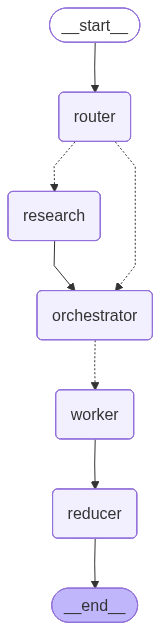

In [115]:
graph = StateGraph(AgentState)
graph.add_node("router", router)
graph.add_node("research", research)
graph.add_node("orchestrator", orchestrator)
graph.add_node("worker", worker)
graph.add_node("reducer", reducer)

graph.add_edge(START, "router")
graph.add_conditional_edges("router", route_next, {"research": "research", "orchestrator": "orchestrator"})
graph.add_edge("research", "orchestrator")
graph.add_conditional_edges("orchestrator", fanout, ["worker"])
graph.add_edge("worker", "reducer")
graph.add_edge("reducer", END)

app = graph.compile()
app

In [116]:
# graph.add_edge(START, "orchestrator")
# graph.add_conditional_edges("orchestrator", fanout,["worker"])
# graph.add_edge("worker", "reducer")
# graph.add_edge("reducer", END)

# app = graph.compile()
# app


In [118]:
out = app.invoke({"topic" : "Machine Learning and its core with the world of technology in 2026"}) 

/home/machine/Agent/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=RouterDecision(need_resea...s comparison for 2026']), input_type=RouterDecision])
  return self.__pydantic_serializer__.to_python(


KeyError: 'need_research'

In [ ]:
# !pip install bytez

In [ ]:
# """
#   pip i bytez
# """

# from bytez import Bytez

# key = "0aeaaedf042c0906946d535638ddde56"
# sdk = Bytez(key)

# # choose Realistic_Vision_V5.1_noVAE
# model = sdk.model("SG161222/Realistic_Vision_V5.1_noVAE")

# # send input to model
# results = model.run("A Man desperate of losing in front of computer")

# print({ "error": results.error, "output": results.output })

{'error': None, 'output': 'https://cdn.bytez.com/model/output/SG161222/Realistic_Vision_V5.1_noVAE/FfDn0TfRWqhZPf2Hr54FH.png'}


In [3]:
!pip install bytez

In [ ]:




from bytez import Bytez
key = "abcd"
sdk = Bytez(key)

# choose vit-base-patch32-384
model = sdk.model("google/vit-base-patch32-384")

# send input to model
results = model.run(" ")

print({ "error": results.error, "output": results.output })

{'error': 'Inference failed. Incorrect image source. Must be a valid URL starting with `http://` or `https://`, a valid path to an image file, or a base64 encoded string. Got  the aeroplane is flying above him and a maths equiation is wreiitenon aeroplane . Failed with Incorrect padding\n\nIf this looks like an issue with the Bytez API - Please contact us in our discord https://discord.gg/ZydhEJTd3R or email us at team@bytez.com.', 'output': None}


In [1]:
!pip install bytez

In [ ]:
"""
  pip i bytez
"""

from bytez import Bytez

key = "abcd"
sdk = Bytez(key)

# choose imagen-4.0-ultra-generate-001
model = sdk.model("google/imagen-4.0-ultra-generate-001")

# send input to model
results = model.run("A boy running on the runway , the aeroplane is flying above him and a maths equiation is wreiitenon aeroplane")

print({ "error": results.error, "output": results.output })

{'error': None, 'output': 'https://cdn.bytez.com/model/output/google/imagen-4.0-ultra-generate-001/IS64JC-E30Hq-VQbBbQeK.png'}


In [6]:
for r in results:
    print(r)

https://cdn.bytez.com/model/output/google/imagen-4.0-ultra-generate-001/IS64JC-E30Hq-VQbBbQeK.png
None
{'generatedImages': [{'image': {'imageBytes': 'iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAAAg3pUWHRSYXcgcHJvZmlsZSB0eXBlIGlwdGMAAAiZTYs7DsIwEAV7nyJH2N28/aSmoqPgArbjlZAiBXH/AosCmNdM8aZcb/fL8nyd+ThGWT5olDUg2LAT5r4wcyexMbWDsQnBTW2Yuhg7ps/3rxX9aymrSXQBR4i3ntFyd7eoq9ZWKcsbuIYghUiq6vkAAAHNaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8P3hwYWNrZXQgYmVnaW49Iu+7vyIgaWQ9Ilc1TTBNcENlaGlIenJlU3pOVGN6a2M5ZCI/PiA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA1LjUuMCI+IDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+IDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiIHhtbG5zOklwdGM0eG1wRXh0PSJodHRwOi8vaXB0Yy5vcmcvc3RkL0lwdGM0eG1wRXh0LzIwMDgtMDItMjkvIiBJcHRjNHhtcEV4dDpEaWdpdGFsU291cmNlRmlsZVR5cGU9IlRyYWluZWRBbGdvcml0aG1pY01lZGlhIiBJcHRjNHhtcEV4dDpEaWdpdGFsU291cmNlVHlwZT0iVHJhaW5lZEFsZ29yaXRobWljTWVkaWEiLz4gPC9yZGY6UkRGPiA8L3g6eG1wbWV0YT4gICA8P3hwYWNrZXQgZW